In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [17]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [18]:
from torch.nn.functional import softmax

In [19]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


<AxesSubplot: >

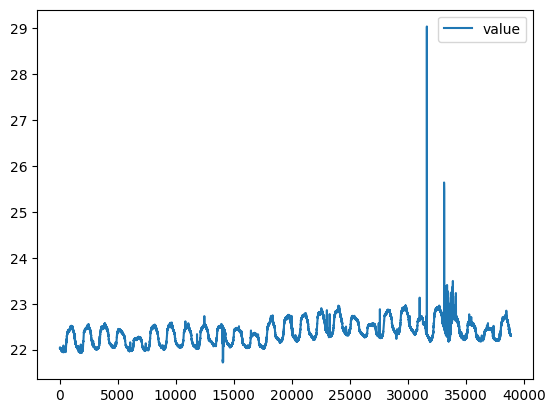

In [20]:
data.plot()

In [21]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment4/online-learning-DLinear']

In [22]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))
        
        
        return x

class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size,stride):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size=kernel_size,stride=stride)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        
        moving_mean = moving_mean.permute(0,2,1)
        
        x = x.permute(0,2,1)
        
        res = torch.cat([x[:,:720,:] - moving_mean[:,0:1,:],x[:,720:,:]-moving_mean[:,1:2,:]],dim=1)
        
        # Classical ma중에서 additive model
        return res,moving_mean

In [23]:
A=FloatTensor([[[1,2,3]],[[4,5,6]]])
B=FloatTensor([[[1,2,3]],[[4,5,6]]])
C=(A*B).sum(dim=2).view(-1,1,1)
D=FloatTensor([[[1,2,3]],[[4,5,6]]])
E=FloatTensor([[[1,2,3]],[[1,2,3]]])
F=(-1*(torch.abs(D-E).sum(dim=2))).view(-1,1,1)

print(F*E)
print(D[:,:,0:2])
#list_f = [C,F]
# for i in list_f:
#     print(i)
#torch.cat([C,F],dim=2)

torch.cat([FloatTensor(),C],dim=2)

tensor([[[ -0.,  -0.,  -0.]],

        [[ -9., -18., -27.]]])
tensor([[[1., 2.]],

        [[4., 5.]]])


tensor([[[14.]],

        [[77.]]])

In [24]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        self.SMALLKERNEL = 60
        
        # Decomposition Kernel Size
        kernel_size = 1440
        self.stride = 1440
        self.decomposition = series_decomp(kernel_size,self.stride)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        

        self.Linear_Seasonal = nn.Linear(2*self.SMALLKERNEL,self.pred_len)
        self.Linear_Trend = nn.Linear(2,self.pred_len)
        self.Linear_plus = nn.Linear(2,1)
        
        
#         self.Kernel_Linear = nn.ModuleList()
#         for i in range(seasonal_init.size(-1)//SMALLKERNEL):
#             self.Kernel_Linear.append(nn.Linear())
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.permute(0,2,1).to(self.device)
        
        
 
        STANDARD = seasonal_init[:,:,-self.SMALLKERNEL:]
        Score_List = []
        Vector_List = []
    
        
        for i in range(self.SMALLKERNEL,seasonal_init.size(-1)-self.SMALLKERNEL+1):
            Comparison_Vector = seasonal_init[:,:,-i-self.SMALLKERNEL:-i]
            Vector_List.append(Comparison_Vector)
            score = (-1*(torch.abs(STANDARD-Comparison_Vector).sum(dim=2))).view(-1,1,1) 
            # 거리를 구한후에 -를 붙여준다
            # 이를 통해 그래프의 모양이 많이 차이나는 것은 가중치를 덜 받게 된다
            Score_List.append(score)
            
        score_tensor = FloatTensor().to(self.device)
        value_tensor = torch.zeros(size=(seasonal_init.size(0),1,self.SMALLKERNEL)).to(self.device)
        
        for i in Score_List:
            score_tensor = torch.cat([score_tensor,i],dim=2)

        Prob_Score = softmax(score_tensor,dim=2)
        
        
#         print(Prob_Score[:,:,0].view(-1,1,1).size())
#         print(Vector_List[0].size())
#         print(value_tensor.size())
        for i in range(Prob_Score.size(2)):
            value_tensor=value_tensor+((Prob_Score[:,:,i].view(-1,1,1))*Vector_List[i])
            # 빈 Tensor와는 덧셈과 같은 텐서연산이 불가능하다
            
        seasonal_input = torch.cat([value_tensor,STANDARD],dim=2)
        seasonal_output = self.Linear_Seasonal(seasonal_input)    
        trend_output = self.Linear_Trend(trend_init)
        new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [25]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [26]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [27]:
torch.manual_seed(42)

In [28]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [29]:
torch.manual_seed(42)

In [30]:
out_list = []
loss_list = []
time_list1 = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    Start = time.time()
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()   
        
    End = time.time()
    
    time_list1.append(End-Start)
    
    scheduler.step() #schedular update
    
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 0.09125875221287603 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 0.07365284990709907 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 0.07062381165689648 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 0.0687539634568486 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 0.067531099702621 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 0.06669731713165611 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 0.06608512356049485 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 0.06561471840498795 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 0.06525869031432656 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 0.06496996380019748 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 0.06473763995464858 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 0.06454408497104357 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 0.064385513

In [31]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.011145792432216695 %
SMAPE 0.0034341980847472087 %
SMAPE 0.0032959764449103095 %
SMAPE 0.01072815739611599 %
SMAPE 0.012108239322515146 %
SMAPE 0.022305219387419584 %
SMAPE 0.01396344895819368 %
SMAPE 0.006982629789220596 %
SMAPE 0.0048055822423904715 %
SMAPE 0.0021877172301429937 %
SMAPE 0.00927992664986732 %
SMAPE 0.0034353292349749154 %
SMAPE 0.016128972272554165 %
SMAPE 0.0011197002223468644 %
SMAPE 0.002358938555786949 %
SMAPE 0.04861458364848659 %
SMAPE 0.06307563827522245 %
SMAPE 0.046533329256817524 %
SMAPE 0.02440771569052913 %
SMAPE 0.003586127888610236 %
SMAPE 0.014421706765858746 %
SMAPE 0.00044050870262424263 %
SMAPE 0.0798074872000143 %
SMAPE 0.042219904699777544 %
SMAPE 0.008305962251355936 %
SMAPE 0.04481818816748273 %
SMAPE 0.046115975021280065 %
SMAPE 0.03806395357457859 %
SMAPE 0.07828032152610831 %
SMAPE 0.08218972518807277 %
SMAPE 0.05084680770551132 %
SMAPE 0.009721646725267874 %
SMAPE 0.002343109271556898 %
SMAPE 0.002533785497092822 %
SMAPE 0.00951983739

SMAPE 0.0814074509544298 %
SMAPE 0.13863077061250806 %
SMAPE 0.13420552510069683 %
SMAPE 0.04239577830594499 %
SMAPE 0.05612266108801123 %
SMAPE 0.034504902244862024 %
SMAPE 0.004368577605497137 %
SMAPE 0.003906123274234119 %
SMAPE 0.0033682885554213726 %
SMAPE 0.0385218799674476 %
SMAPE 0.015919541058281084 %
SMAPE 0.02706327085981286 %
SMAPE 0.0202829546965404 %
SMAPE 0.03223870505235027 %
SMAPE 0.008942029362358994 %
SMAPE 0.0021296248972717535 %
SMAPE 0.00043406446746274696 %
SMAPE 0.008047746357092933 %
SMAPE 0.0007844009064825741 %
SMAPE 0.0027242013231116857 %
SMAPE 0.016211909778036215 %
SMAPE 0.002677944771988905 %
SMAPE 0.010837135650646701 %
SMAPE 0.009071135303855726 %
SMAPE 0.023356966586732142 %
SMAPE 0.07269621960585937 %
SMAPE 0.016469641698797943 %
SMAPE 0.03059619423149229 %
SMAPE 0.020222800026544974 %
SMAPE 0.012960332565654655 %
SMAPE 0.0011686435288780217 %
SMAPE 0.09080587615608238 %
SMAPE 0.11314583447529004 %
SMAPE 0.03791767096882381 %
SMAPE 0.0051794367481079

SMAPE 0.008805055300797449 %
SMAPE 0.0025495482169333172 %
SMAPE 0.022649685125685437 %
SMAPE 0.009617137075622395 %
SMAPE 0.01794510723851772 %
SMAPE 0.02166808111735463 %
SMAPE 0.023970739532160223 %
SMAPE 0.0540960497019114 %
SMAPE 0.05197650342597626 %
SMAPE 0.0023187291694455325 %
SMAPE 0.01445608971817336 %
SMAPE 0.018301015504675888 %
SMAPE 0.008377251517863726 %
SMAPE 0.013533327923035188 %
SMAPE 0.010764871816924426 %
SMAPE 0.00015862002254607432 %
SMAPE 0.00830950902880545 %
SMAPE 0.0017687352664097489 %
SMAPE 0.0020610879465721155 %
SMAPE 0.014810681372807723 %
SMAPE 0.0005855020179055259 %
SMAPE 0.00010547300897911781 %
SMAPE 8.29872677172716e-05 %
SMAPE 0.030591837297663464 %
SMAPE 0.004716592408847475 %
SMAPE 0.009942642782668543 %
SMAPE 0.008407371207574954 %
SMAPE 0.011734266641724389 %
SMAPE 0.031009717385131808 %
SMAPE 0.006006602858022347 %
SMAPE 0.04668915148067754 %
SMAPE 0.005023072621810343 %
SMAPE 0.03564935378199152 %
SMAPE 0.001945110486964552 %
SMAPE 0.001538

SMAPE 0.09451509130303748 %
SMAPE 0.00501400186385581 %
SMAPE 0.0013167287601447697 %
SMAPE 0.004984273658728 %
SMAPE 0.01046275729202506 %
SMAPE 0.023349325162541845 %
SMAPE 0.017008936426663013 %
SMAPE 0.004365135624638583 %
SMAPE 0.0014783514261438313 %
SMAPE 0.030189701308188436 %
SMAPE 0.011118643612576307 %
SMAPE 0.016416347580275215 %
SMAPE 0.010150899128944957 %
SMAPE 0.0006681412935165554 %
SMAPE 0.007603137999915077 %
SMAPE 0.028056853484343947 %
SMAPE 0.004340166369779297 %
SMAPE 0.02230357686158868 %
SMAPE 0.012470698085905951 %
SMAPE 0.0005432928799677939 %
SMAPE 0.0027415410425248865 %
SMAPE 0.0011419120716880116 %
SMAPE 0.004702979473094615 %
SMAPE 0.011679970807932705 %
SMAPE 0.008072324575564949 %
SMAPE 0.0007936599634916774 %
SMAPE 0.008280373667318486 %
SMAPE 0.00804197144348251 %
SMAPE 0.01675997853688216 %
SMAPE 0.03835241594811123 %
SMAPE 0.06576692744420143 %
SMAPE 0.011164741256919797 %
SMAPE 0.00012616752896121852 %
SMAPE 0.014248430410219727 %
SMAPE 0.00129853

SMAPE 0.002015849657063029 %
SMAPE 0.00904776742463298 %
SMAPE 0.0020021993904322244 %
SMAPE 0.019739201355662317 %
SMAPE 0.007077045257872784 %
SMAPE 0.05214725337282289 %
SMAPE 0.0005200584509879036 %
SMAPE 0.0014472200490729392 %
SMAPE 0.009014017781844075 %
SMAPE 0.022413340690810912 %
SMAPE 0.022718928665653948 %
SMAPE 0.0008920576621349595 %
SMAPE 0.04332991776027484 %
SMAPE 0.0046287478718340935 %
SMAPE 0.0011481529995620576 %
SMAPE 0.002602712458454448 %
SMAPE 0.004562075842670765 %
SMAPE 0.0011000390955757666 %
SMAPE 0.021768365681225532 %
SMAPE 0.01766997930621983 %
SMAPE 0.009787724542398735 %
SMAPE 0.001637394481520005 %
SMAPE 0.0004171235115180139 %
SMAPE 0.012827172569259915 %
SMAPE 0.0028116710921466392 %
SMAPE 0.005337456291613307 %
SMAPE 0.0019094135031991752 %
SMAPE 0.026110327651622356 %
SMAPE 0.010353473157643123 %
SMAPE 0.001131784577722783 %
SMAPE 0.05564164237875957 %
SMAPE 0.006290856901564724 %
SMAPE 0.0046171273668278445 %
SMAPE 0.03351247521277401 %
SMAPE 0.0

SMAPE 0.0009719284575453457 %
SMAPE 0.013851224833949516 %
SMAPE 0.018916746462480205 %
SMAPE 0.005893637085137016 %
SMAPE 0.013947231350499578 %
SMAPE 0.039553324599864936 %
SMAPE 0.016093714813891324 %
SMAPE 0.003193326195088275 %
SMAPE 0.013542623803033393 %
SMAPE 0.0700975020226906 %
SMAPE 0.054808661405786545 %
SMAPE 0.030948670122484145 %
SMAPE 0.010170420725302165 %
SMAPE 0.007274607440287184 %
SMAPE 0.0004869936165050604 %
SMAPE 0.004238124225310003 %
SMAPE 0.003368844748180777 %
SMAPE 0.0017333906763639109 %
SMAPE 0.008511877765457143 %
SMAPE 0.0029599539389693064 %
SMAPE 0.022596032365356677 %
SMAPE 0.04464348669375795 %
SMAPE 0.016394937240931995 %
SMAPE 0.00019144768839396423 %
SMAPE 0.03502416220010218 %
SMAPE 0.037876413138292264 %
SMAPE 0.013714339043445989 %
SMAPE 0.0041352771079345985 %
SMAPE 0.0022268887488436917 %
SMAPE 0.009944156965786988 %
SMAPE 0.012903487132803093 %
SMAPE 0.007969401507097018 %
SMAPE 0.0027888475302688676 %
SMAPE 0.010688022699994804 %
SMAPE 0.0

SMAPE 0.001292223069526699 %
SMAPE 0.008159657395239606 %
SMAPE 0.0068967236287349465 %
SMAPE 0.007646495582562807 %
SMAPE 0.013128471354988847 %
SMAPE 0.0032296817622565754 %
SMAPE 0.027735547129282168 %
SMAPE 0.00495220049495515 %
SMAPE 0.0054474202136916006 %
SMAPE 0.0025332627233183302 %
SMAPE 0.004494511884949759 %
SMAPE 0.003873029651458637 %
SMAPE 0.006466715364354058 %
SMAPE 0.00020470061640764925 %
SMAPE 0.021307106457840064 %
SMAPE 0.0058621680711112845 %
SMAPE 0.0020436368470484467 %
SMAPE 0.013646776480484844 %
SMAPE 0.004929557683993835 %
SMAPE 0.004377925387331061 %
SMAPE 0.006336264326179729 %
SMAPE 0.003597312500673411 %
SMAPE 0.0005119047746404704 %
SMAPE 0.0003753548857758915 %
SMAPE 0.019093551756895977 %
SMAPE 0.01196630894415307 %
SMAPE 0.0013023229467421515 %
SMAPE 0.00810208998905182 %
SMAPE 0.0032957624478484604 %
SMAPE 0.008426866727006654 %
SMAPE 0.004473133571565313 %
SMAPE 0.0035787720971711683 %
SMAPE 0.0187313365540831 %
SMAPE 0.012993173087238574 %
SMAPE 

SMAPE 0.045610580084030516 %
SMAPE 0.02198598892823611 %
SMAPE 0.07383772861794569 %
SMAPE 0.0629805033095181 %
SMAPE 0.06868937093531713 %
SMAPE 0.05236407578922809 %
SMAPE 0.04198449061368592 %
SMAPE 0.03705319363507442 %
SMAPE 0.011745107907913166 %
SMAPE 0.014503758148521229 %
SMAPE 0.011099760157378569 %
SMAPE 0.0010502071838089932 %
SMAPE 9.742461531914158e-05 %
SMAPE 0.005717616988277996 %
SMAPE 0.031105237794690762 %
SMAPE 0.0016373996786143152 %
SMAPE 0.024030922371991892 %
SMAPE 0.0005228982438794105 %
SMAPE 0.08623629657085985 %
SMAPE 0.011647621044744483 %
SMAPE 0.00011882239502369886 %
SMAPE 0.04569508977874648 %
SMAPE 0.0011695235437798601 %
SMAPE 0.018458689546605456 %
SMAPE 0.027314706623656093 %
SMAPE 0.005191349370221587 %
SMAPE 0.00457624150531899 %
SMAPE 0.0028967781350814903 %
SMAPE 0.002187184212850468 %
SMAPE 0.008804742889509498 %
SMAPE 0.00028114039008642067 %
SMAPE 0.0166185820965552 %
SMAPE 0.0051085809310222885 %
SMAPE 0.004109951054743988 %
SMAPE 0.01228716

SMAPE 0.012097053636487942 %
SMAPE 0.009049022702413367 %
SMAPE 0.013173865135911454 %
SMAPE 0.03830588829600856 %
SMAPE 0.023620537188662638 %
SMAPE 0.06150871952922899 %
SMAPE 0.04394357192177267 %
SMAPE 0.011522130912538842 %
SMAPE 0.0007269725062997168 %
SMAPE 0.04322750614221604 %
SMAPE 0.01474019436740548 %
SMAPE 0.07600981957511976 %
SMAPE 0.0009115426332044763 %
SMAPE 0.017249322414329527 %
SMAPE 0.001368049579909325 %
SMAPE 0.02053500954275478 %
SMAPE 0.0033862512940601164 %
SMAPE 0.016496404757646133 %
SMAPE 0.02698130072354843 %
SMAPE 0.005125459117948594 %
SMAPE 0.007909054404102278 %
SMAPE 0.009623670223184888 %
SMAPE 0.0012775758534999682 %
SMAPE 0.0016306867675695003 %
SMAPE 0.012365569040497347 %
SMAPE 0.0038986929369144723 %
SMAPE 0.007791003041120348 %
SMAPE 0.0059662615926683316 %
SMAPE 0.0008128237807909499 %
SMAPE 0.011529176271899644 %
SMAPE 0.057407038359087885 %
SMAPE 0.03034831614832001 %
SMAPE 0.00695292090988886 %
SMAPE 0.0011530901738012744 %
SMAPE 0.0017739

SMAPE 0.0002856459104663145 %
SMAPE 0.03909340714744758 %
SMAPE 0.03256960987346247 %
SMAPE 0.015383151574894784 %
SMAPE 0.0007193116060904003 %
SMAPE 0.010752409123028883 %
SMAPE 0.03758863690018188 %
SMAPE 0.08105200552381575 %
SMAPE 0.0005392841081004462 %
SMAPE 0.0005642338123124091 %
SMAPE 0.012105864943187328 %
SMAPE 0.019614145262295324 %
SMAPE 0.003986198487567094 %
SMAPE 0.006664644242462714 %
SMAPE 0.010229773965605204 %
SMAPE 0.03658530239772517 %
SMAPE 0.0008100904548058452 %
SMAPE 0.025508475064270893 %
SMAPE 0.005865968249025855 %
SMAPE 0.002034311752268536 %
SMAPE 0.04775995298405178 %
SMAPE 0.048147021094337106 %
SMAPE 0.020065635722403385 %
SMAPE 0.0588113160629291 %
SMAPE 0.0031294249674402867 %
SMAPE 0.004515529135090901 %
SMAPE 0.03850437013898045 %
SMAPE 0.05677853908855468 %
SMAPE 0.03893001070537139 %
SMAPE 0.0016070872610782772 %
SMAPE 0.0010494680743562412 %
SMAPE 0.004872840544777546 %
SMAPE 0.01643066784603775 %
SMAPE 0.0006361792428535296 %
SMAPE 0.000392017

SMAPE 0.002822303049470065 %
SMAPE 0.004506020849817105 %
SMAPE 0.01570856765201256 %
SMAPE 0.00028298810012472586 %
SMAPE 0.004887054040324301 %
SMAPE 0.00029971831429520535 %
SMAPE 0.0029639292324361577 %
SMAPE 0.0002228022571557631 %
SMAPE 0.0020852404560471882 %
SMAPE 0.0010119396861654195 %
SMAPE 0.0568665287296426 %
SMAPE 8.3584070608822e-05 %
SMAPE 8.851036585867405 %
SMAPE 14.0014878064394 %
SMAPE 12.224012181162834 %
SMAPE 11.020437844097614 %
SMAPE 3.16692996583879 %
SMAPE 2.2201374005526304 %
SMAPE 2.574044018983841 %
SMAPE 0.40871891006827354 %
SMAPE 0.5364630483090878 %
SMAPE 0.0019520628666356288 %
SMAPE 0.1336239234437926 %
SMAPE 0.4668180546723306 %
SMAPE 0.5725855608470738 %
SMAPE 0.02161318290819736 %
SMAPE 0.006038370849523744 %
SMAPE 0.2835534625919536 %
SMAPE 0.05601440241230194 %
SMAPE 0.002783297217590075 %
SMAPE 0.208396733738482 %
SMAPE 0.19635375126381402 %
SMAPE 0.7915311828255653 %
SMAPE 1.7769407648593187 %
SMAPE 1.4250915152952075 %
SMAPE 1.005894445814192

SMAPE 0.012154237817050273 %
SMAPE 0.0027861952339875984 %
SMAPE 0.0007012479746748568 %
SMAPE 0.012253766532069221 %
SMAPE 0.004429188258512795 %
SMAPE 0.03592035389829107 %
SMAPE 0.008635226836076981 %
SMAPE 0.05489422622486018 %
SMAPE 0.014101652102610274 %
SMAPE 0.002127135825602977 %
SMAPE 0.0008662520609092893 %
SMAPE 0.011821272231330227 %
SMAPE 0.005481689466115824 %
SMAPE 0.003314164817183496 %
SMAPE 0.0004389370851072272 %
SMAPE 0.004707930682130268 %
SMAPE 0.010349614386960582 %
SMAPE 0.0037044367583121125 %
SMAPE 0.001483732923674097 %
SMAPE 0.003037480801253878 %
SMAPE 0.027569525343096757 %
SMAPE 0.017585536357913156 %
SMAPE 0.012274307172049248 %
SMAPE 0.0631590014527319 %
SMAPE 0.0018586202228547677 %
SMAPE 0.0013821527073645257 %
SMAPE 0.01757011507721984 %
SMAPE 0.017436945763591893 %
SMAPE 0.006922031005537122 %
SMAPE 0.0027022960414413433 %
SMAPE 0.026637336503426923 %
SMAPE 0.04660413937017438 %
SMAPE 0.003964937766411936 %
SMAPE 0.006518754240971702 %
SMAPE 0.0293

SMAPE 0.011016038116828497 %
SMAPE 0.006565355772949033 %
SMAPE 0.020187021440506214 %
SMAPE 0.02905783864480327 %
SMAPE 0.02379030891893308 %
SMAPE 0.050012452848022804 %
SMAPE 0.008741239311461868 %
SMAPE 0.06267614691751078 %
SMAPE 0.003030904968596815 %
SMAPE 0.0074841012176563035 %
SMAPE 0.047085017838981 %
SMAPE 0.05506742477882653 %
SMAPE 0.08952000725548714 %
SMAPE 0.004504177941072385 %
SMAPE 0.0004108891355798505 %
SMAPE 0.019663737601149478 %
SMAPE 0.02629576727758831 %
SMAPE 0.04736417451931629 %
SMAPE 0.01410597873521624 %
SMAPE 0.15130569960456342 %
SMAPE 0.024205042479053418 %
SMAPE 0.019484625271047662 %
SMAPE 0.00016391269024040866 %
SMAPE 0.1255984550807625 %
SMAPE 0.11753015010617673 %
SMAPE 0.05580289702629671 %
SMAPE 0.03451748806401156 %
SMAPE 0.015695190659926084 %
SMAPE 0.003619581129086669 %
SMAPE 0.01098819267195239 %
SMAPE 0.00404585789719647 %
SMAPE 0.07519025448709726 %
SMAPE 0.12310845794854686 %
SMAPE 0.04818455773056485 %
SMAPE 0.009838542985733056 %
SMA

SMAPE 0.031367974798286014 %
SMAPE 0.011064401111696043 %
SMAPE 0.01570926208157175 %
SMAPE 0.026318174027778696 %
SMAPE 0.009515922844315128 %
SMAPE 0.016216942766220654 %
SMAPE 0.0042092972821308194 %
SMAPE 0.01200886974558557 %
SMAPE 0.0050045827121110165 %
SMAPE 0.013775864599296028 %
SMAPE 0.013847511896301514 %
SMAPE 0.00721802642024727 %
SMAPE 0.008090200637894895 %
SMAPE 0.008757519242600154 %
SMAPE 0.027057548004734144 %
SMAPE 0.02026575878696235 %
SMAPE 0.020306857352579755 %
SMAPE 0.004704182559933656 %
SMAPE 0.0357761162210295 %
SMAPE 0.0013401387232505613 %
SMAPE 0.004734133683243158 %
SMAPE 0.010681112347711519 %
SMAPE 0.003297362506941681 %
SMAPE 0.0060380740648042774 %
SMAPE 0.0007284348717959688 %
SMAPE 0.012061056767734613 %
SMAPE 0.08340080740163103 %
SMAPE 0.00995107535339912 %
SMAPE 0.011418975004602316 %
SMAPE 0.03743824550292629 %
SMAPE 0.01868772462383106 %
SMAPE 0.002690272932987625 %
SMAPE 0.009137222138299705 %
SMAPE 0.010192230583371042 %
SMAPE 0.00237145802

SMAPE 0.0034889190178262193 %
SMAPE 0.025175921225667253 %
SMAPE 0.017580061522835422 %
SMAPE 0.002230588257006616 %
SMAPE 0.04316354093316477 %
SMAPE 0.048921141831669956 %
SMAPE 0.01259910421313748 %
SMAPE 0.043237379199126735 %
SMAPE 0.021082023358374613 %
SMAPE 0.009932635022188663 %
SMAPE 0.005712421627038111 %
SMAPE 0.0017659449617326572 %
SMAPE 0.0021545217519474136 %
SMAPE 0.025471391102783514 %
SMAPE 0.019682062638821662 %
SMAPE 0.004327722543344237 %
SMAPE 0.004965590500376038 %
SMAPE 0.0007841034907158928 %
SMAPE 0.027811380249090686 %
SMAPE 0.05318016653473023 %
SMAPE 0.0014347442046585002 %
SMAPE 0.03274801342286082 %
SMAPE 0.014357273678399451 %
SMAPE 0.027424278761714053 %
SMAPE 0.08342027541948482 %
SMAPE 0.034089129944277374 %
SMAPE 0.09225919540040195 %
SMAPE 0.0006940026717643377 %
SMAPE 0.009622363435632053 %
SMAPE 0.004009857001115336 %
SMAPE 0.0032097791845373536 %
SMAPE 0.0005176386099776664 %
SMAPE 0.0095725450441293 %
SMAPE 0.007447955188894184 %
SMAPE 0.025008

KeyboardInterrupt: 

In [32]:
len(pred_list)

4136

In [33]:
pred_list

[22.429109573364258,
 22.419702529907227,
 22.40612030029297,
 22.418188095092773,
 22.398149490356445,
 22.420433044433594,
 22.403244018554688,
 22.412321090698242,
 22.40399169921875,
 22.406660079956055,
 22.422578811645508,
 22.436603546142578,
 22.420434951782227,
 22.415090560913086,
 22.404878616333008,
 22.442943572998047,
 22.40346908569336,
 22.433813095092773,
 22.40986442565918,
 22.411767959594727,
 22.429222106933594,
 22.4368839263916,
 22.39272117614746,
 22.413917541503906,
 22.397289276123047,
 22.432931900024414,
 22.402372360229492,
 22.434059143066406,
 22.393321990966797,
 22.429960250854492,
 22.39723014831543,
 22.4054012298584,
 22.411474227905273,
 22.40696907043457,
 22.42241859436035,
 22.403764724731445,
 22.428070068359375,
 22.40677261352539,
 22.410676956176758,
 22.397642135620117,
 22.40093231201172,
 22.382408142089844,
 22.407569885253906,
 22.41033935546875,
 22.396320343017578,
 22.378551483154297,
 22.415937423706055,
 22.38667869567871,
 22.4030

In [37]:
target=list(target.values.reshape(-1))

AttributeError: 'list' object has no attribute 'values'

In [38]:
# target = target[:4136]

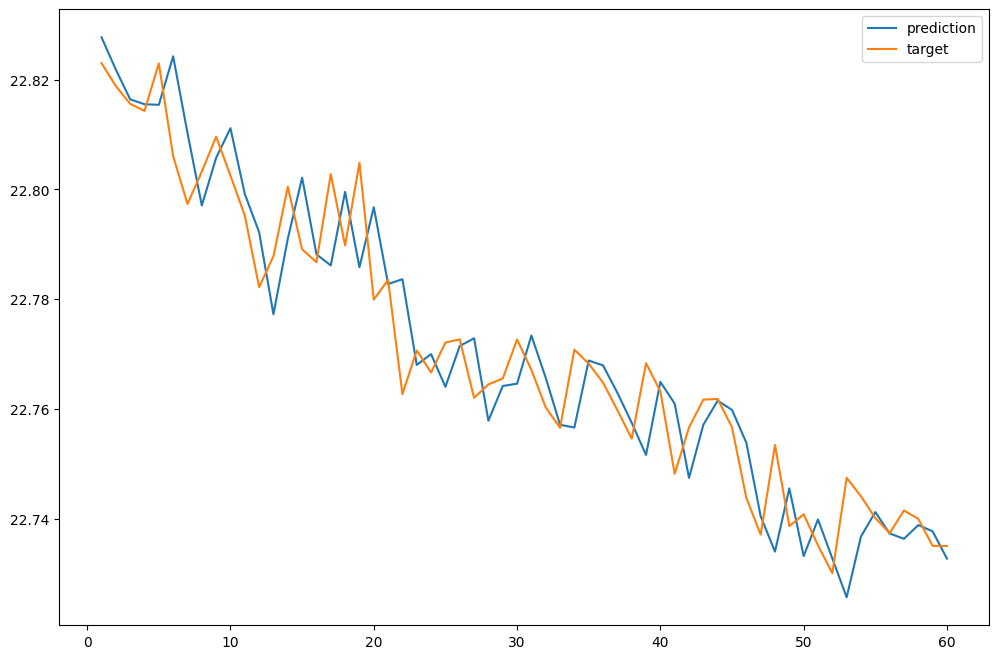

In [39]:
# fig,axes = plt.subplots(1,1,figsize=(12,8))
# axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
# axes.plot(np.arange(1,61),target[-60:],label='target')
# axes.legend()

In [42]:
# print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item()*100,'%')
# print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item())
# print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item()*100,'%')

SMAPE 0.07206894224509597 %
RMSE 0.1190459206700325
MAPE 0.0717850576620549 %


In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [ ]:
np.array(pred_list)

In [ ]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

In [ ]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

In [ ]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

In [ ]:
len(time_list)

In [ ]:
np.mean(time_list) 

In [ ]:
np.mean(time_list1) #pretraining 1Epoch 도는데 걸리는 시간